In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load preprocessed data for DNN
file_path = '/content/drive/MyDrive/NLP_Workspace/Data/DNN_Binary_Labeled/'

df_data = pd.read_csv(file_path + "F_vs_T_emojidata.csv")

In [3]:
df_data.head(10)
df_data.isnull().any()
df_data = df_data.dropna(how='any',axis=0)

In [4]:
df_data.describe()

,label,0,1,2,3,4,5,6,7,8,...,293,294,295,296,297,298,299,0.1,1.1,2.1
count,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,...,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000,198653.000000
mean,0.499761,0.562122,0.363533,0.091042,1.252131,-0.870792,0.233279,0.810727,-0.786417,0.888413,...,0.031206,-0.645197,-0.402591,0.356290,-0.580655,0.229664,0.011043,0.052811,0.030924,0.023831
std,0.500001,0.645156,0.549723,0.526521,0.832085,0.707455,0.596314,0.727362,0.661622,0.692256,...,0.564176,0.668902,0.619498,0.655813,0.597604,0.571985,0.554392,0.304747,0.153201,0.115947
min,0.000000,-5.266113,-2.658478,-5.858398,-2.196899,-4.441893,-3.266663,-6.679688,-5.572296,-6.213135,...,-5.292908,-5.431641,-7.542297,-4.842529,-6.928711,-4.550781,-3.087524,0.000000,0.000000,0.000000
25%,0.000000,0.099365,0.000000,-0.208374,0.593750,-1.359131,-0.116638,0.247559,-1.203003,0.339251,...,-0.285522,-1.084763,-0.761581,-0.055695,-0.948669,-0.124268,-0.314697,0.000000,0.000000,0.000000
50%,0.000000,0.492737,0.294434,0.072914,1.206543,-0.815917,0.189453,0.741638,-0.709167,0.842590,...,0.031250,-0.580811,-0.339355,0.288818,-0.515381,0.179199,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.975342,0.696335,0.385376,1.819977,-0.312531,0.585812,1.311615,-0.284897,1.364258,...,0.351959,-0.160156,-0.001953,0.758568,-0.158813,0.570816,0.318481,0.000000,0.000000,0.000000
max,1.000000,5.275883,5.686523,6.454956,8.592773,2.355958,5.489990,4.490234,1.919220,4.568617,...,5.368652,4.992218,3.496752,5.151085,3.291504,6.698242,5.911865,28.000000,0.974747,1.000000


In [5]:
fetched_data = df_data.to_numpy()
len(fetched_data), len(fetched_data[0])

(198653, 304)

In [6]:
LENGTH_DATA = len(fetched_data)

import random
train_example_nums = int(0.85 * LENGTH_DATA)
test_example_nums = int(0.15 * LENGTH_DATA)

random_ids = [i for i in range(LENGTH_DATA)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:]

len(random_train_ids), len(random_test_ids)

(168855, 29798)

In [7]:
X_train = torch.as_tensor(fetched_data[random_train_ids, 1:])
Y_train = torch.as_tensor(fetched_data[random_train_ids, 0]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids, 1:])
Y_test = torch.as_tensor(fetched_data[random_test_ids, 0]).type(torch.int64)

In [8]:
print(X_train, X_train.shape)

tensor([[ 1.0661,  1.3010,  0.0551,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3434,  0.4401, -0.4271,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.5310,  0.5859, -0.0317,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4155, -0.2456,  0.1240,  ...,  0.0000,  0.0000,  0.0000],
        [-1.1775,  1.1608,  0.1592,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64) torch.Size([168855, 303])


In [9]:
print(Y_train, Y_train.shape)

tensor([0, 0, 1,  ..., 0, 0, 1]) torch.Size([168855])


In [10]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.posts = X

  def __len__(self):
    return len(self.posts)

  def __getitem__(self, index):
    post = self.posts[index]
    label = self.labels[index]
    return post, label

In [11]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(1)
tensor([0, 1, 1,  ..., 0, 0, 0])


In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        posts, labels = batch 
        out = self(posts.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        posts, labels = batch
        out = self(posts.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [19]:
class DNN(ClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(303, 256)
    self.fc2 = torch.nn.Linear(256, 128)
    self.fc3 = torch.nn.Linear(128, 128)
    self.fc4 = torch.nn.Linear(128, 2)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    return x

In [20]:
model = DNN()
model.to(device)

DNN(
  (fc1): Linear(in_features=303, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, num_workers=1, shuffle = True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4, num_workers=1, pin_memory=True)

In [22]:
history = [evaluate(model, test_dataloader)]
history

[{'val_loss': 0.6935791373252869, 'val_acc': 0.49835506081581116}]

In [23]:
history += fit(20, 0.0001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 0.6918, val_acc: 0.5286
Epoch [1], val_loss: 0.6900, val_acc: 0.5449
Epoch [2], val_loss: 0.6874, val_acc: 0.5503
Epoch [3], val_loss: 0.6841, val_acc: 0.5569
Epoch [4], val_loss: 0.6814, val_acc: 0.5632
Epoch [5], val_loss: 0.6792, val_acc: 0.5679
Epoch [6], val_loss: 0.6778, val_acc: 0.5719
Epoch [7], val_loss: 0.6770, val_acc: 0.5720
Epoch [8], val_loss: 0.6759, val_acc: 0.5735
Epoch [9], val_loss: 0.6753, val_acc: 0.5736
Epoch [10], val_loss: 0.6750, val_acc: 0.5742
Epoch [11], val_loss: 0.6743, val_acc: 0.5757
Epoch [12], val_loss: 0.6739, val_acc: 0.5770
Epoch [13], val_loss: 0.6735, val_acc: 0.5787
Epoch [14], val_loss: 0.6733, val_acc: 0.5780
Epoch [15], val_loss: 0.6736, val_acc: 0.5795
Epoch [16], val_loss: 0.6726, val_acc: 0.5812
Epoch [17], val_loss: 0.6724, val_acc: 0.5803
Epoch [18], val_loss: 0.6721, val_acc: 0.5812
Epoch [19], val_loss: 0.6718, val_acc: 0.5820


In [25]:
history += fit(10, 0.00001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 0.6717, val_acc: 0.5827
Epoch [1], val_loss: 0.6717, val_acc: 0.5821
Epoch [2], val_loss: 0.6717, val_acc: 0.5825
Epoch [3], val_loss: 0.6717, val_acc: 0.5826
Epoch [4], val_loss: 0.6716, val_acc: 0.5829
Epoch [5], val_loss: 0.6716, val_acc: 0.5830
Epoch [6], val_loss: 0.6716, val_acc: 0.5819
Epoch [7], val_loss: 0.6716, val_acc: 0.5830
Epoch [8], val_loss: 0.6715, val_acc: 0.5831
Epoch [9], val_loss: 0.6716, val_acc: 0.5831


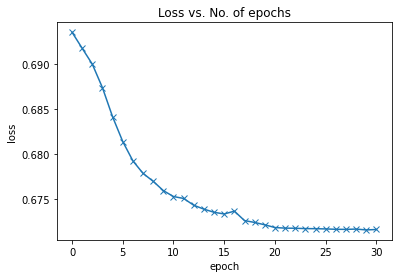

In [26]:
plot_losses(history)

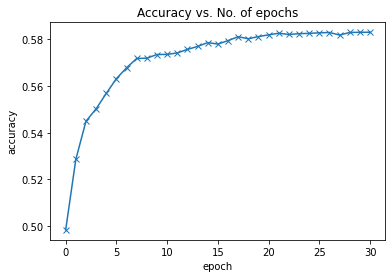

In [27]:
plot_accuracies(history)

In [28]:
evaluate(model, test_dataloader)

{'val_loss': 0.6715824007987976, 'val_acc': 0.5830972790718079}

In [29]:
torch.save(model.state_dict(), 'emotion_classification-feedforward.pth')